# Task

### Pre-defined code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
import scipy.signal as sig
import scipy.signal
style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading all the images in the drive
gt_images = []

for files in tqdm(natsorted(glob('/content/drive/My Drive/ES666CV/images/B/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images) # Only possible because all images are of same size

100%|██████████| 6/6 [00:00<00:00, 118.64it/s]


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

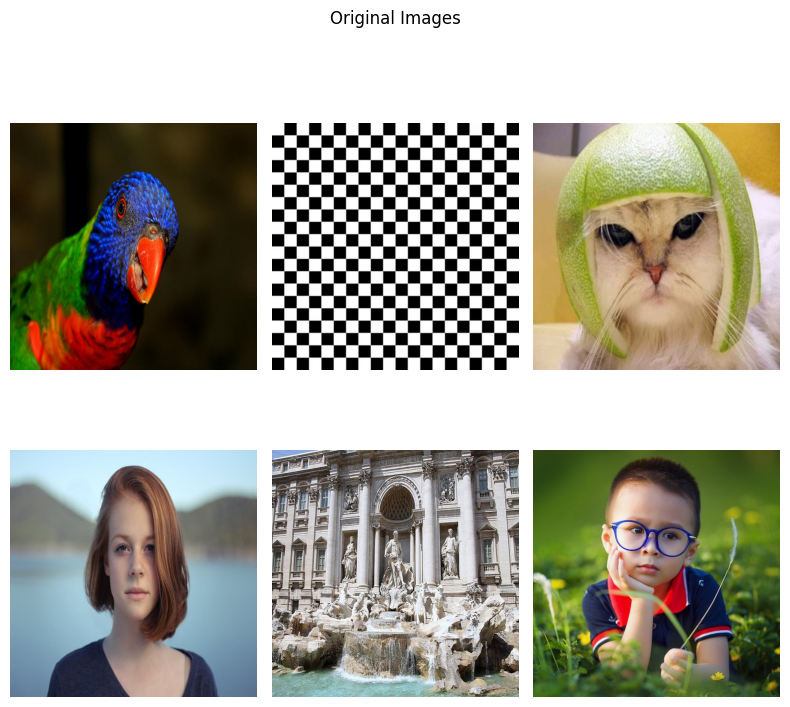

In [ ]:
show_image_grid(gt_images, 2, 3, 'Original Images', figsize=8)

### Q1 [2 Marks]

Implement Gaussian Pyramid Downsampling method from scratch.Compare it with Opencv resize method. What difference do you observe when you resize an image with Gaussian Pyramid approach and Opencv approach.

References:
1. [Gaussian & Laplacian pyramid	construction](https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf)
2. [Multi-Scale Representation](https://medium.com/jun94-devpblog/cv-4-multi-scale-representation-gaussian-and-laplacian-pyramid-527ca4c4831c)

In [ ]:
def pad_image_to_divisible(image, K, pad_value=0):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the padding needed for height and width
    pad_h = (K - (h % K)) % K  # Padding needed for height
    pad_w = (K - (w % K)) % K  # Padding needed for width

    # Compute the padding to add to top/bottom and left/right
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Pad the image: (top, bottom), (left, right), and (no padding on channels)
    if len(image.shape) == 3:  # For RGB images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                              mode='constant', constant_values=pad_value)
    else:  # For grayscale images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant', constant_values=pad_value)

    return padded_image

In [ ]:
def gaussian_pyramid(image, levels,pad = True):
    pyramid = [image]
    no_pad_pyramid = [image]
    for i in range(levels - 1):
        # Apply Gaussian blur and downsample by a factor of 2
        gauss_image = cv2.GaussianBlur(no_pad_pyramid[-1], (5, 5), 0)
        # Write code here
        downsampled_image = []
        height,width,channels = gauss_image.shape
        for i in range(0,height,2):
          row =[]
          for j in range(0,width,2):
            ch =[]
            for k in range(channels):
              window = gauss_image[i:i+2,j:j+2,k]
              ch.append(np.mean(window))
            row.append(ch)
          downsampled_image.append(row)
        image = np.array(downsampled_image,dtype = image.dtype)
        no_pad_pyramid.append(image)
        # print(image.shape)
        if(pad):
          image = pad_image_to_divisible(image, pyramid[0].shape[0])
        pyramid.append(image)
    try:
      return np.array(pyramid)
    except:
      return pyramid

def opencv_resize(inp_image, levels):
    pyramid = []
    h, w    = inp_image.shape[:2]
    for i in range(levels):
        # Apply Gaussian blur and downsample by a factor of 2
        inp_image = cv2.GaussianBlur(inp_image, (5, 5), 0)
        # Write code here
        image = cv2.resize(inp_image, (h//2**i, w//2**i))

        image = pad_image_to_divisible(image, min(h, w))
        pyramid.append(image)

    return np.array(pyramid)

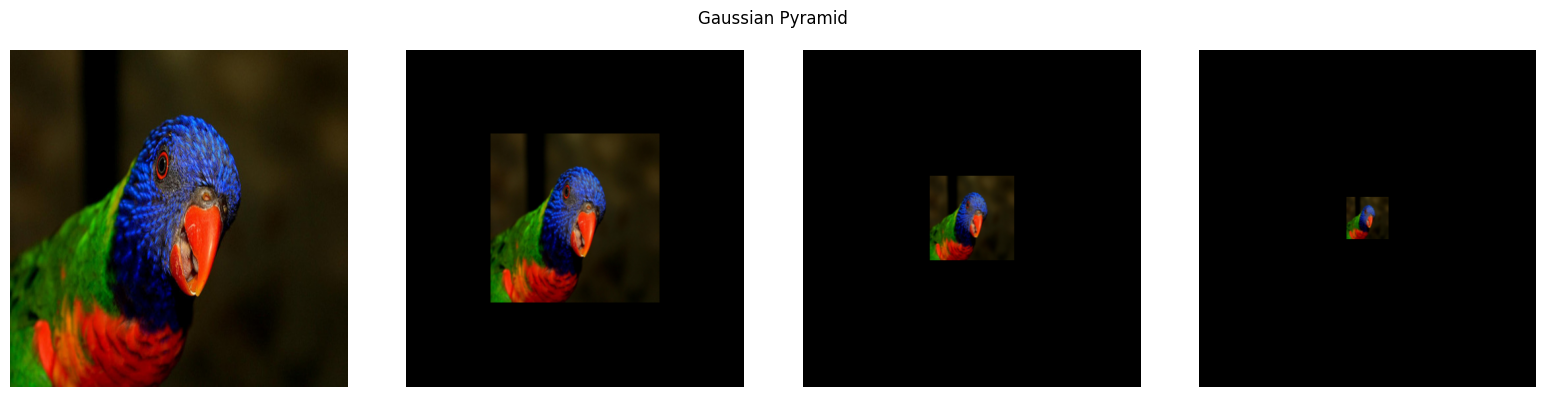

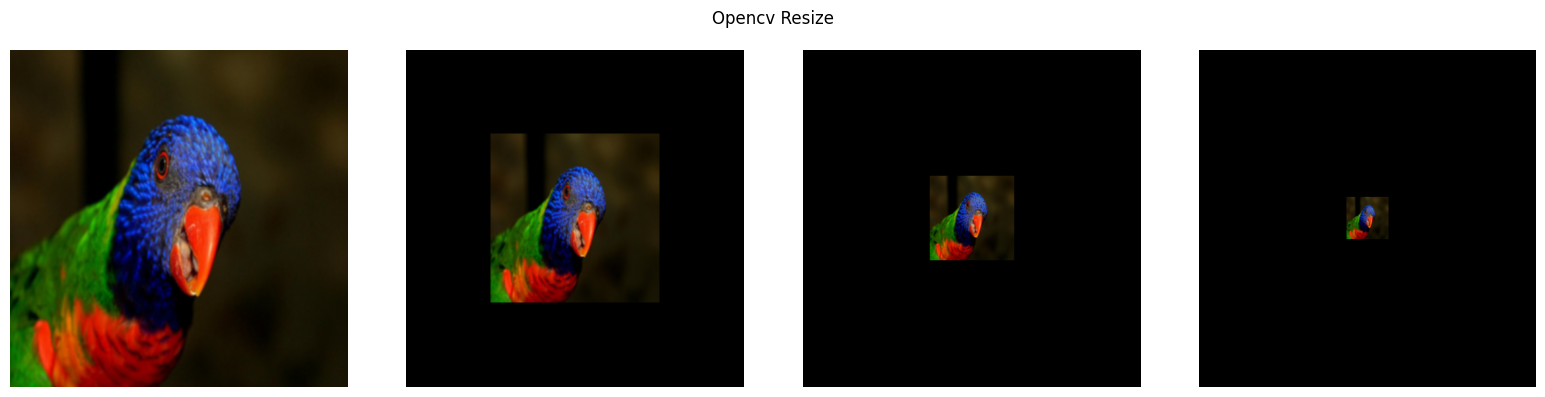

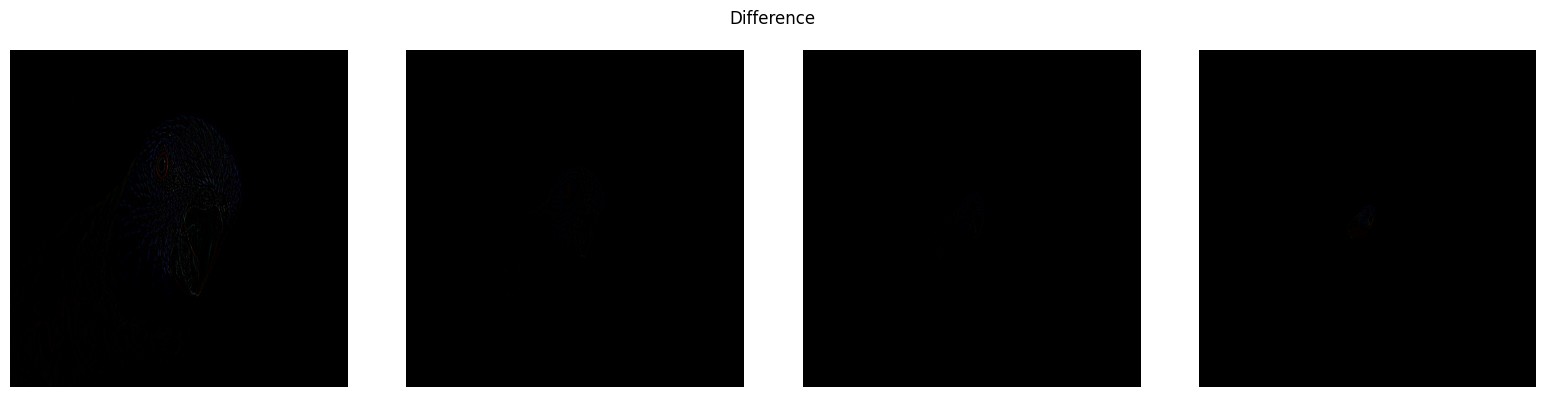

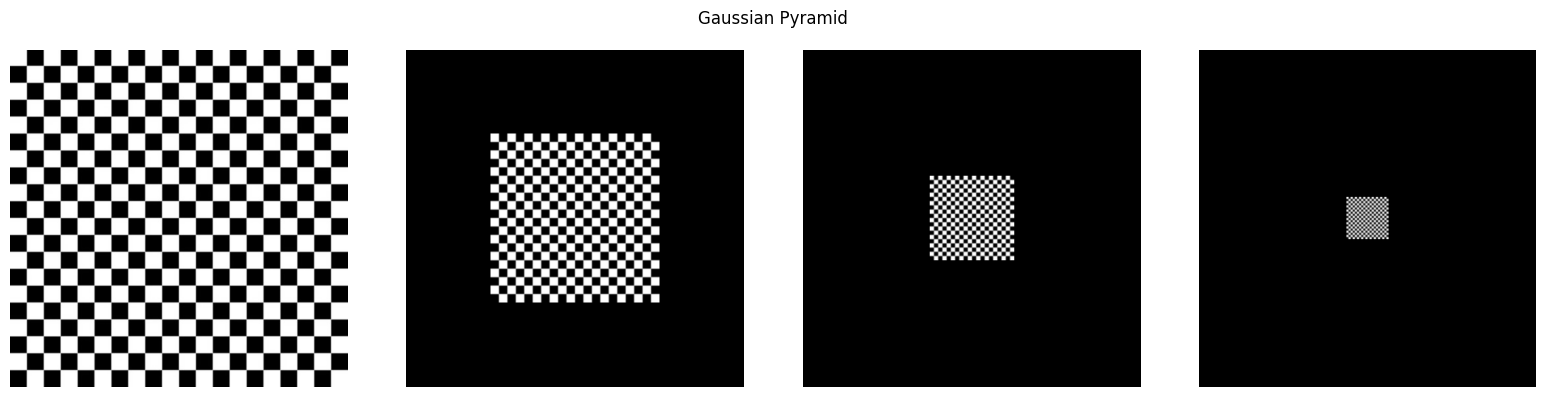

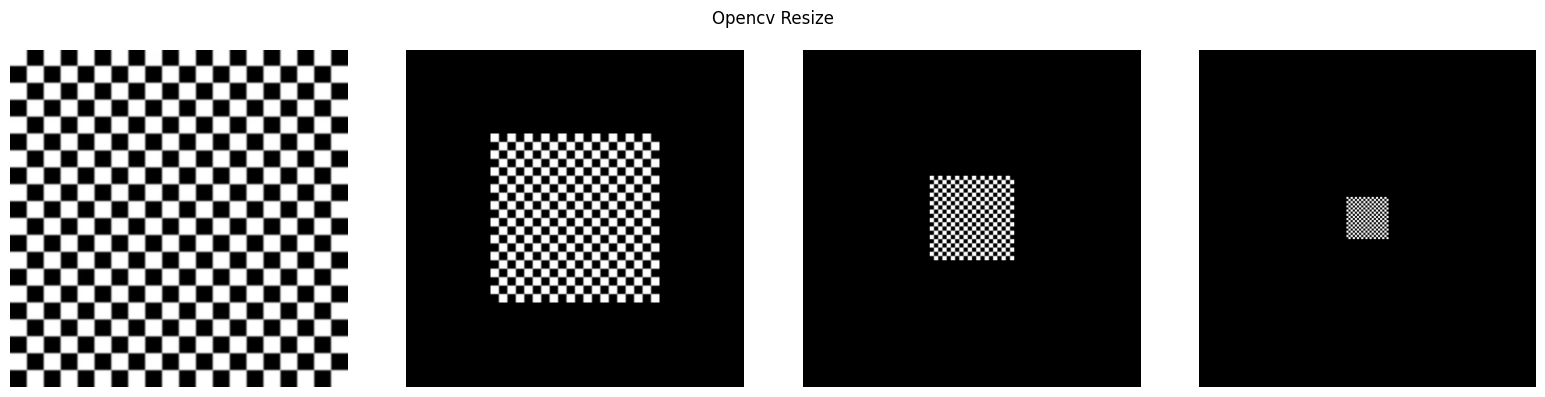

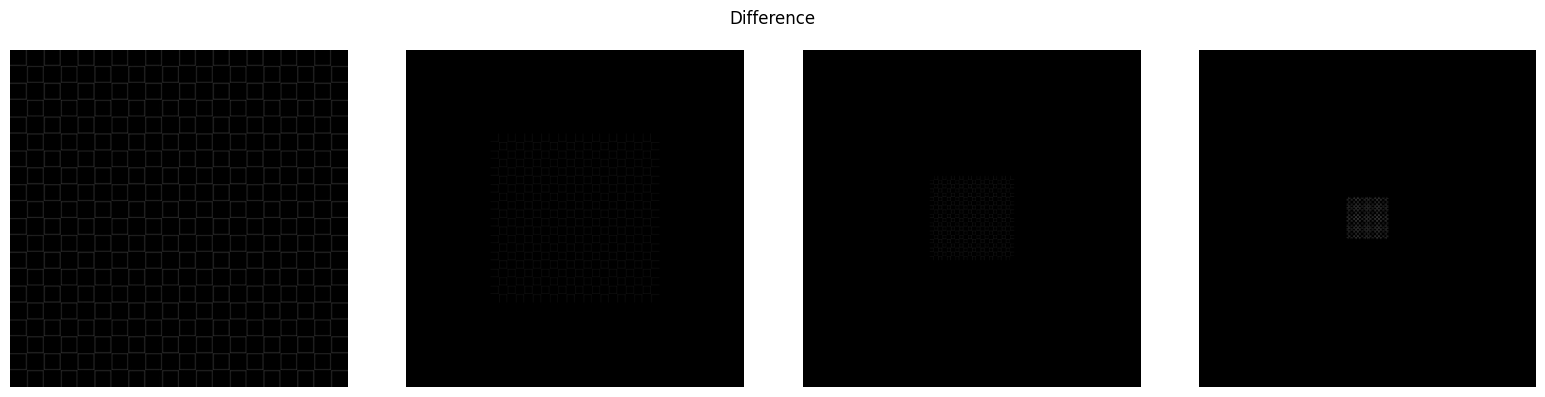

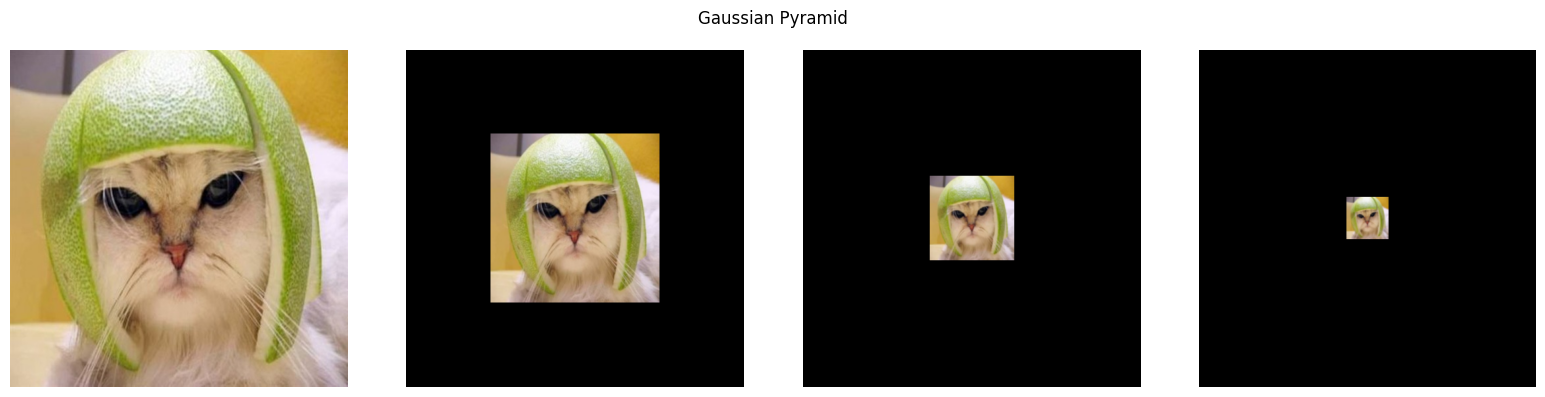

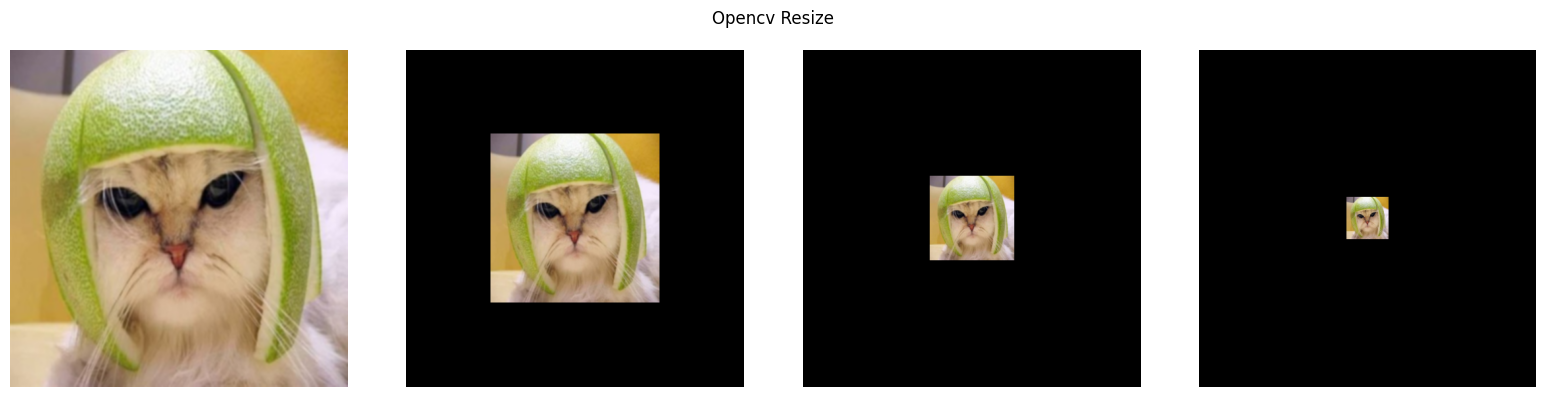

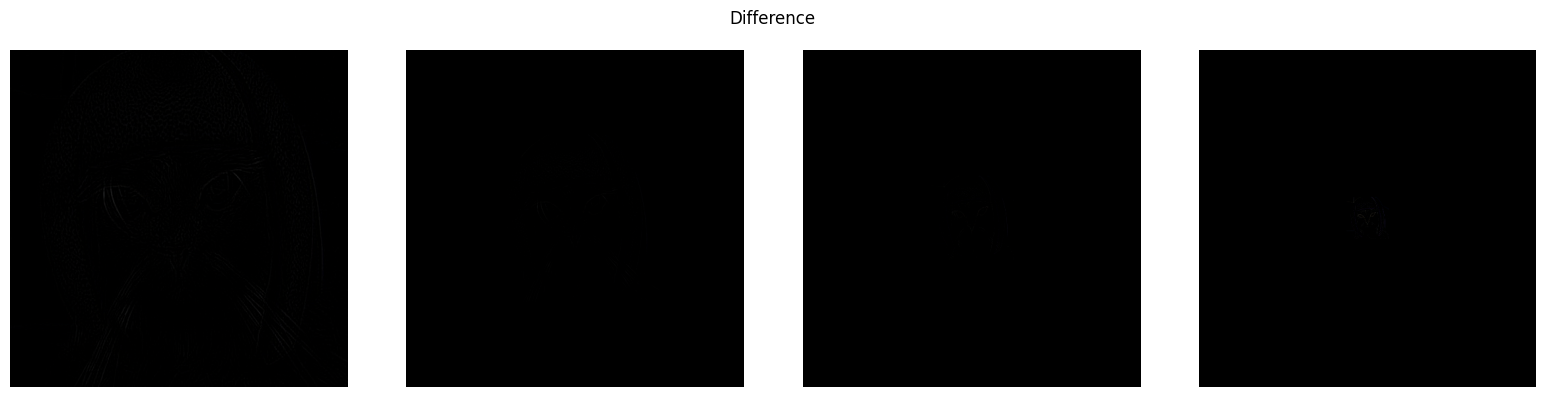

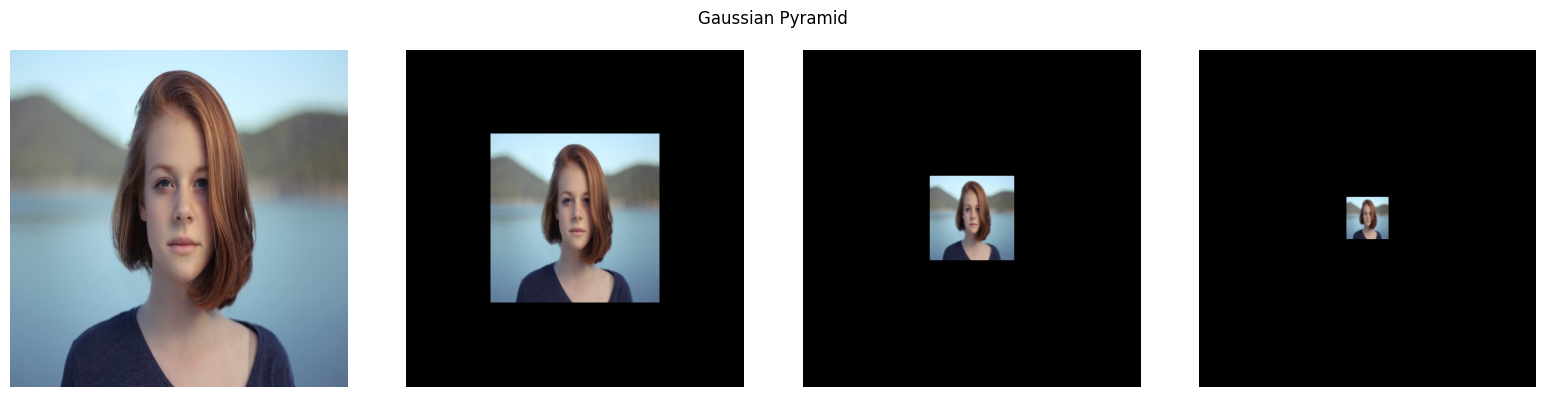

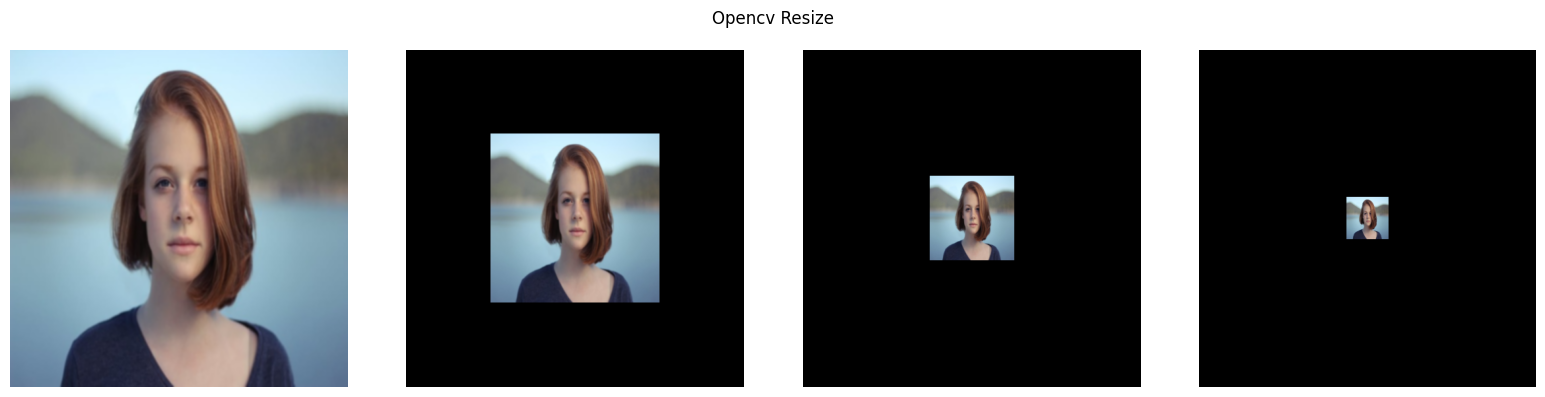

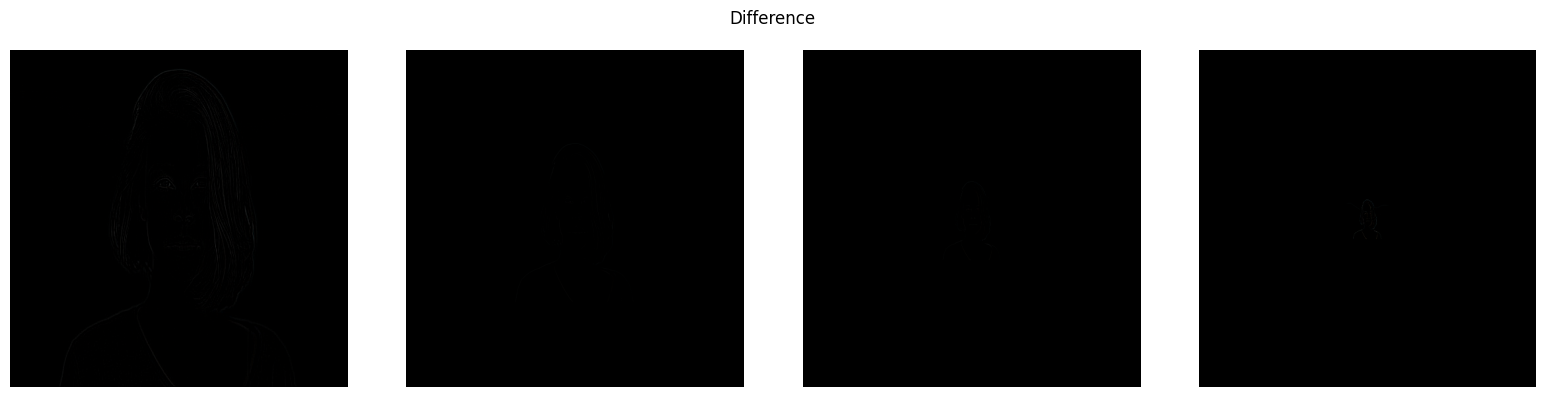

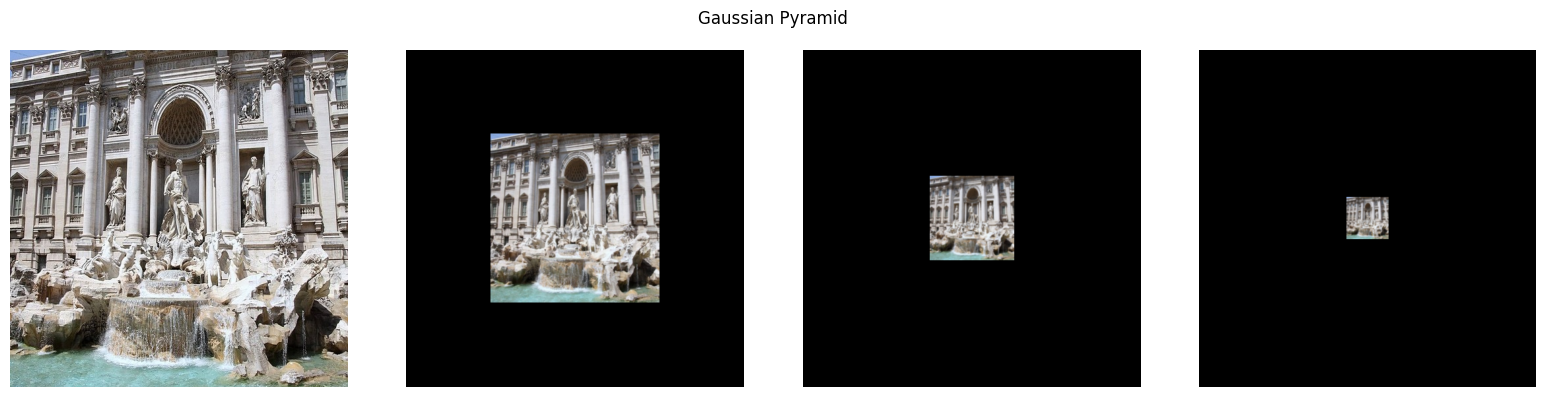

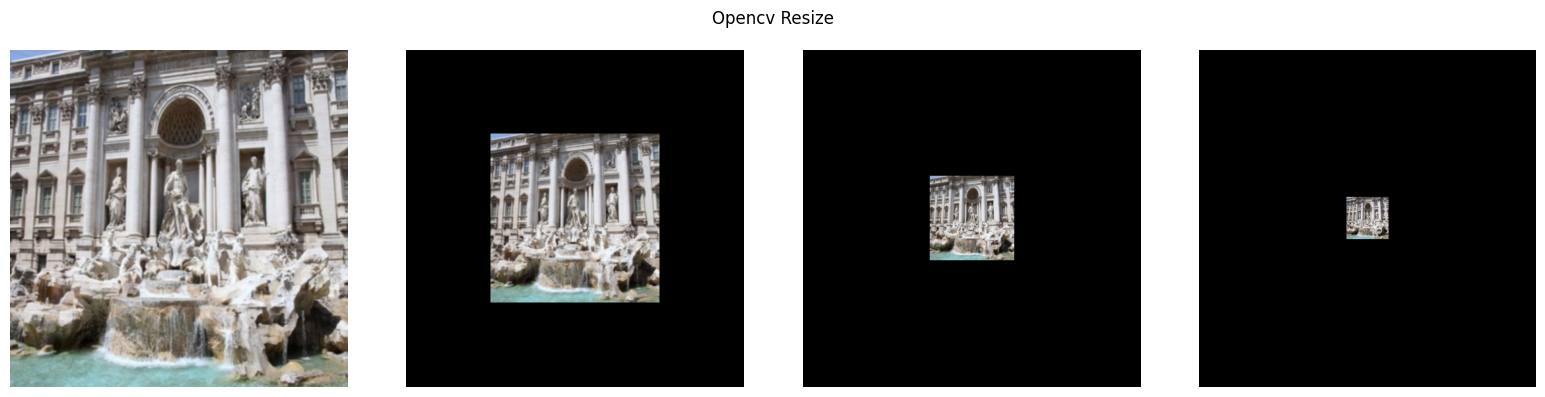

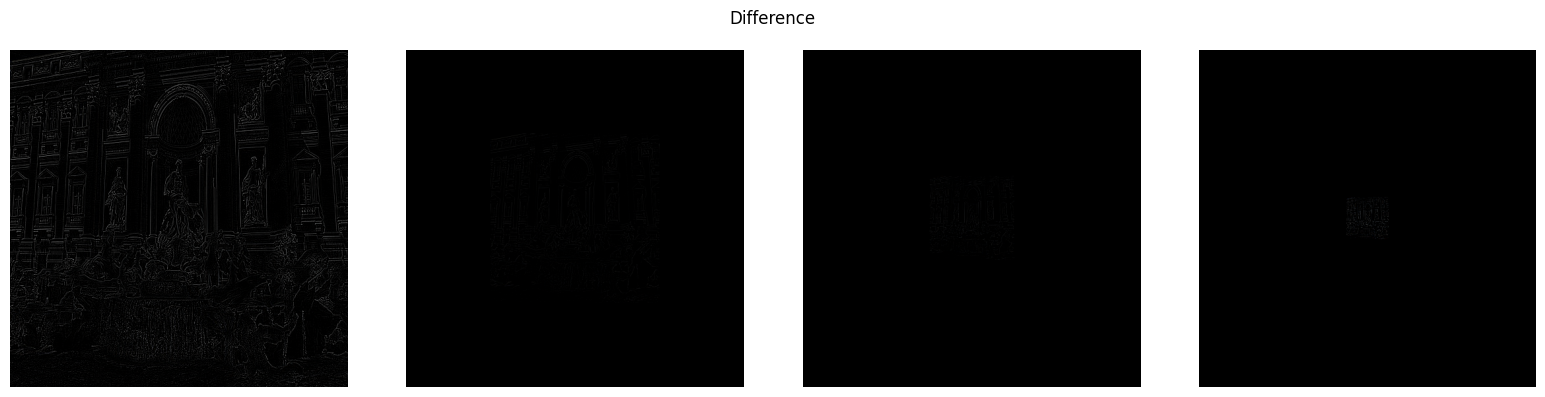

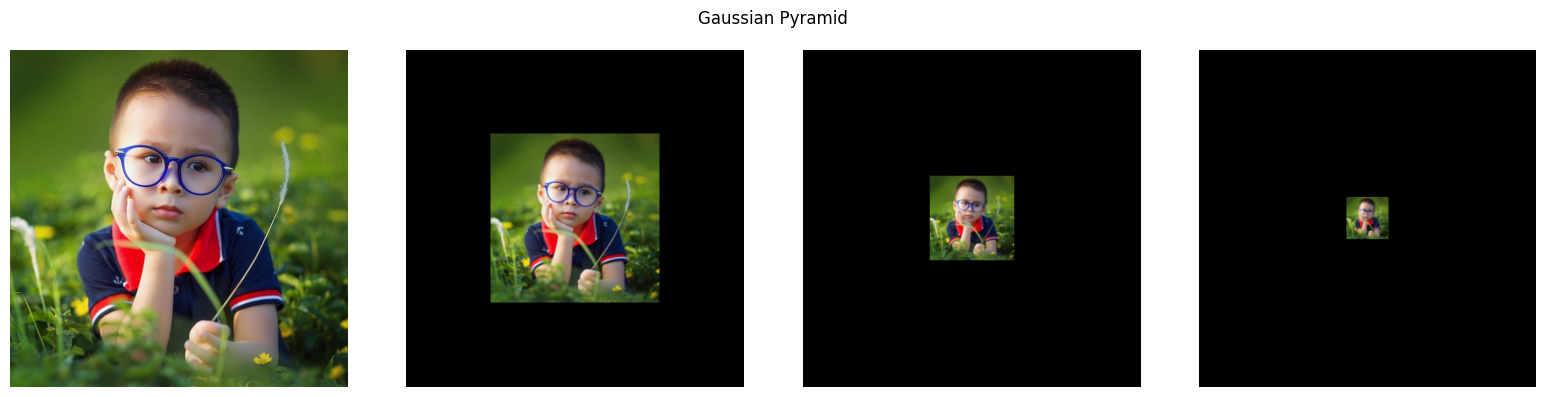

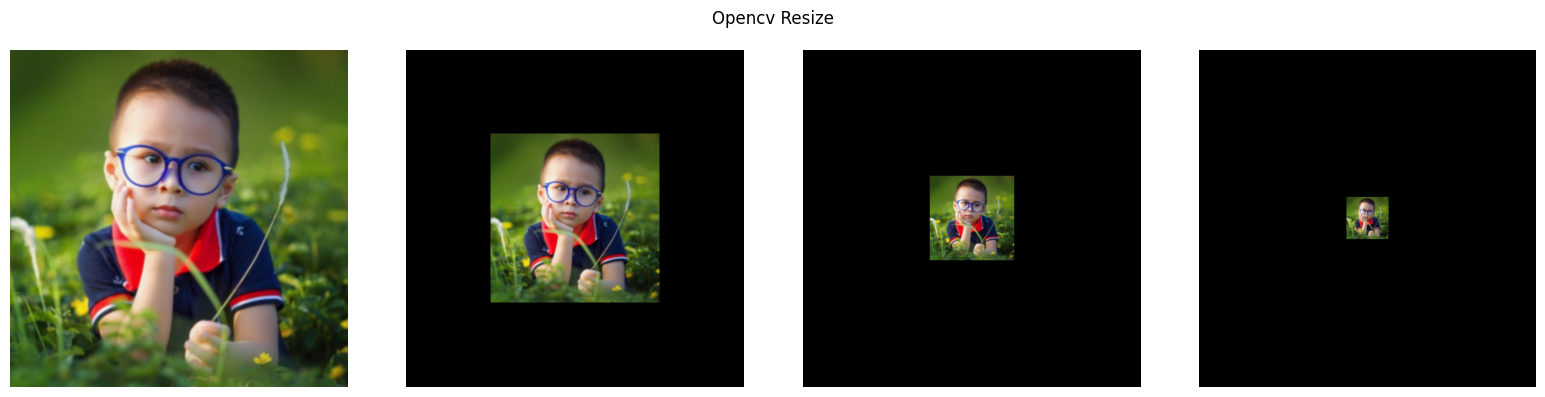

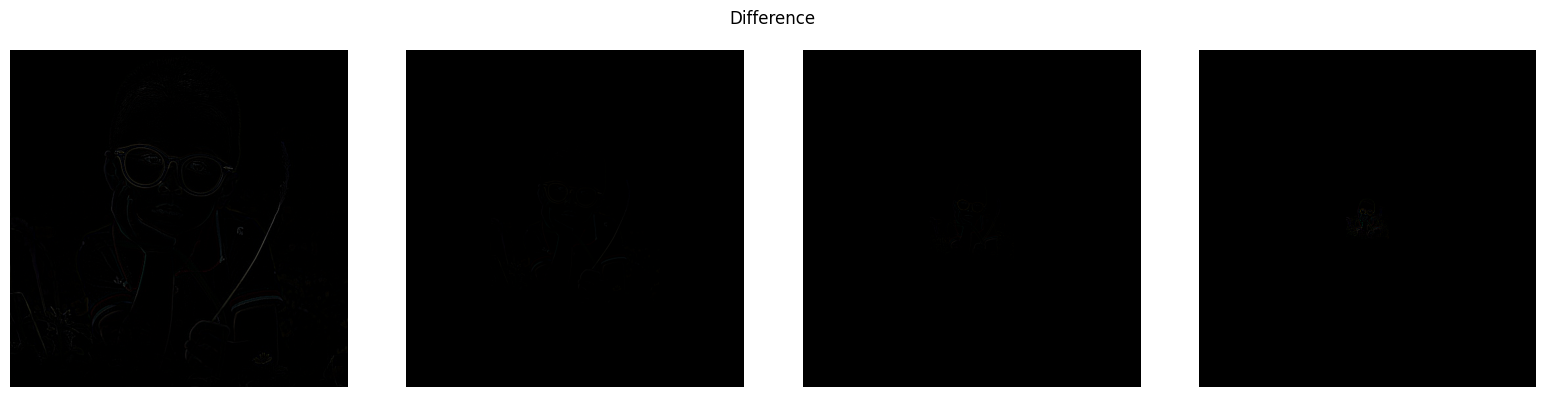

In [ ]:
for idx, image in enumerate(gt_images):

    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)

    diff = []
    for gauss_img, open_img in zip(s_image_pyramids, s_image_opecv_resize):
        diff.append(cv2.subtract(gauss_img, open_img))
    diff = np.array(diff)

    show_image_grid(s_image_pyramids, 1, 4, 'Gaussian Pyramid', figsize=16)
    show_image_grid(s_image_opecv_resize, 1, 4, 'Opencv Resize', figsize=16)
    show_image_grid(diff, 1, 4, 'Difference', figsize=16)

### Q2 [4 Marks]

You have to implement image blending technique using Laplacian Pyramids from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Image Blending Using Laplacian Pyramids](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f)

In [ ]:
def upsample_image(image):
  height,width,channels = image.shape
  reconstructed_image = np.zeros(shape = (2*height,2*width,channels),dtype =image.dtype)
  for i in range(height):
    for j in range(width):
      for k in range(channels):
        reconstructed_image[2 * i, 2 * j, k] = image[i, j, k]          # Top-left
        reconstructed_image[2 * i, 2 * j + 1, k] = image[i, j, k]      # Top-right
        reconstructed_image[2 * i + 1, 2 * j, k] = image[i, j, k]      # Bottom-left
        reconstructed_image[2 * i + 1, 2 * j + 1, k] = image[i, j, k]  # Bottom-right
  cv2.GaussianBlur(reconstructed_image, (5, 5), 0, dst=reconstructed_image)
  return reconstructed_image

def pyramid_differences(pyramid_a,pyramid_b,levels = 6):
    pyramid_a_differences =[]
    pyramid_b_differences =[]
    for i in range(levels -1):
      pyramid_a_differences.append(cv2.subtract(pyramid_a[i],upsample_image(pyramid_a[i+1])))
      pyramid_b_differences.append(cv2.subtract(pyramid_b[i],upsample_image(pyramid_b[i+1])))
    return pyramid_a_differences,pyramid_b_differences

def create_masks(shape,dtype):
  mask = np.zeros(shape,dtype = dtype)
  mask[:,:(shape[1]//2)+1,:] = 1
  flipped_mask = 1 - mask
  return mask,flipped_mask

def apply_mask(pyramid_a_differences,pyramid_b_differences,levels = 6):
    masked_pyramid =[]
    for i in range(levels -1):
      pyramid_a_difference = pyramid_a_differences[i]
      pyramid_b_difference = pyramid_b_differences[i]

      mask,flipped_mask = create_masks(pyramid_a_difference.shape,pyramid_a_difference.dtype)

      masked_image_a = pyramid_a_difference * mask
      masked_image_b = pyramid_b_difference*flipped_mask

      masked_image = cv2.add(masked_image_a,masked_image_b)
      masked_pyramid.append(masked_image)

    return masked_pyramid

def blending(prev_image,masked_pyramid,levels = 6):
  for i in range(levels -2,0,-1):
      prev_image = cv2.add(prev_image,masked_pyramid[i])
      if i!=0:
        prev_image = upsample_image(prev_image)
  return prev_image

def normalize(image,alpha=0,beta=1):
  image = np.array(image,dtype = np.float32)
  minval = np.min(image)
  maxval = np.max(image)
  normalized_image = (image - minval)/(maxval - minval)*(beta-alpha) +alpha
  return normalized_image

def laplacian_pyramid_blend_images(image_a, image_b):
    blended_image = None

    # Write your code here
    levels = 6
    image_a = normalize(image_a)
    image_b = normalize(image_b)
    image_a_pyramids = gaussian_pyramid(image_a, levels=levels,pad = False)
    image_b_pyramids = gaussian_pyramid(image_b, levels=levels,pad = False)
    image_a_pyramids_differences, image_b_pyramids_differences = pyramid_differences(image_a_pyramids,
                                                                                      image_b_pyramids,
                                                                                      levels = levels)
    masked_pyramid = apply_mask(image_a_pyramids_differences,image_b_pyramids_differences,levels = levels)


    image1 = upsample_image(image_a_pyramids[-1])
    mask,flipped_mask = create_masks(image1.shape,image1.dtype)
    image1 = image1*mask
    image2 = upsample_image(image_b_pyramids[-1])*flipped_mask
    image_prev = cv2.add(image1,image2)

    blended_image = blending(image_prev,masked_pyramid,levels = levels)
    blended_image = normalize(blended_image,alpha =0,beta = 255)
    blended_image = np.array(blended_image).astype(np.uint8)
    if blended_image is None:
        return image_a
    return blended_image

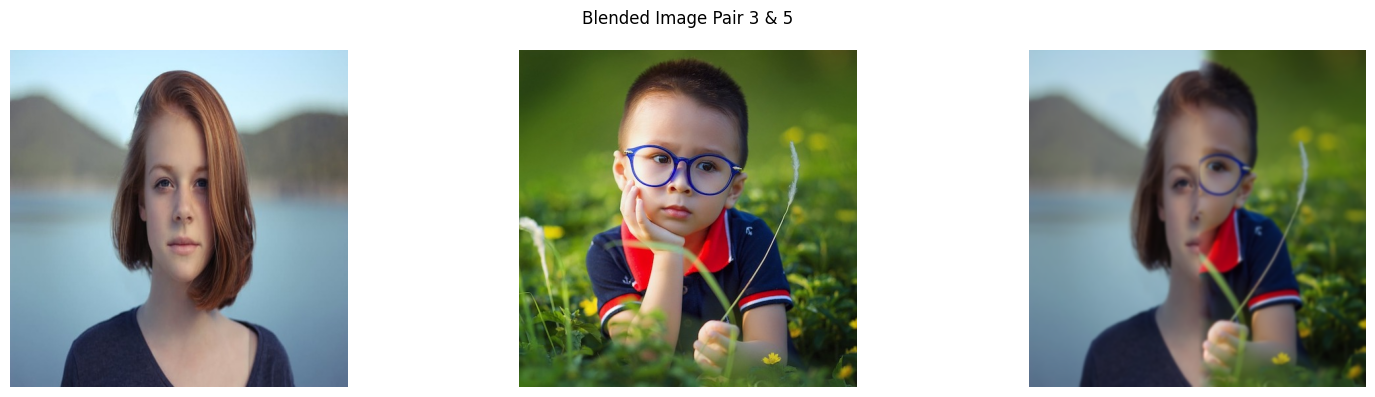

In [ ]:
blended_image = laplacian_pyramid_blend_images(gt_images[3], gt_images[5])
collage = np.array([gt_images[3], gt_images[5], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image Pair 3 & 5', figsize=16)

### Q3 [4 Marks]

Implement Harris and Hessian Corner Detector algorithm from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Harris and Hessian Corner Detector](https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd)

In [ ]:
from scipy.ndimage import convolve
def sobel_filter(image):
  kernel_x = np.array([[1, 0, -1],
                      [2, 0, -2],
                      [1, 0, -1]])
  kernel_y = kernel_x.T
  grad_x = convolve(image, kernel_x)
  grad_y = convolve(image, kernel_y)
  return grad_x, grad_y

def corner_response_fn(grad_x,grad_y,alpha):

    grad_xx = grad_x*grad_x
    grad_yy = grad_y*grad_y
    grad_xy = grad_x*grad_y

    Mxx = cv2.GaussianBlur(grad_xx, (5,5), 0)
    Myy = cv2.GaussianBlur(grad_yy, (5,5), 0)
    Mxy = cv2.GaussianBlur(grad_xy, (5,5), 0)

    M = np.array([[Mxx,Mxy],[Mxy,Myy]])
    det = Mxx*Myy - Mxy**2
    trace = Mxx+Myy
    Response = det -alpha *(trace**2)
    return Response


def detect_harris_corner(image):
    corner_image  = None
    alpha = 0.04
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    grad_x,grad_y = sobel_filter(gray_image)
    response = corner_response_fn(grad_x,grad_y,alpha)
    dst = response
    corner_image = image.copy()
    corner_image[dst>0.01*dst.max(),:]=[0,0,255]
    return corner_image

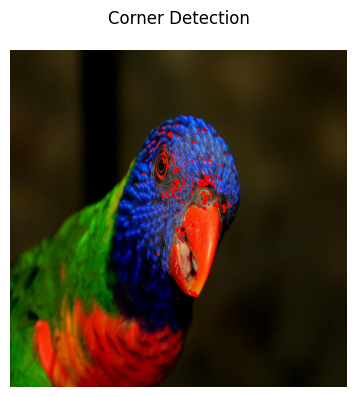

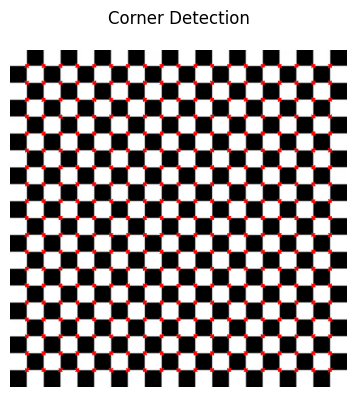

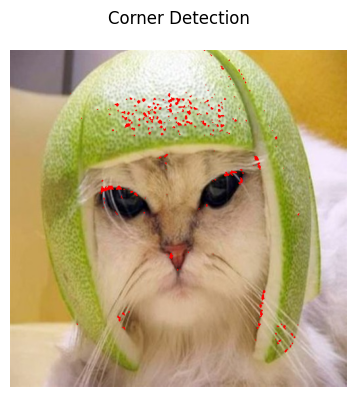

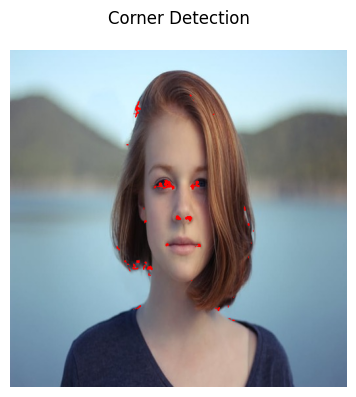

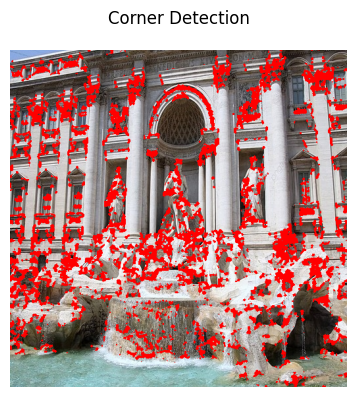

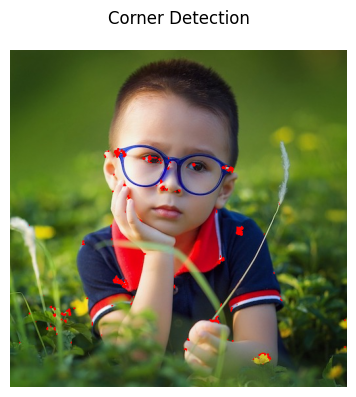

In [ ]:
for image in gt_images:
    corner_image = detect_harris_corner(image)
    show_image_grid(corner_image, 1, 1, 'Corner Detection', figsize=16)